# SCGEN:  Batch-Removal

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "pytorch"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scgen[tutorials]

In [2]:
import logging
import scanpy as sc
import scgen

In [3]:
logger = logging.getLogger("scvi.inference.autotune")
logger.setLevel(logging.WARNING)

### Loading Train Data

In [4]:
train = sc.read(
    "./tests/data/pancreas.h5ad",
    backup_url="https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1"
)

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata

In [5]:
train.obs["cell_type"] = train.obs["celltype"].tolist()
sc.pp.neighbors(train)
sc.tl.umap(train)

... storing 'cell_type' as categorical


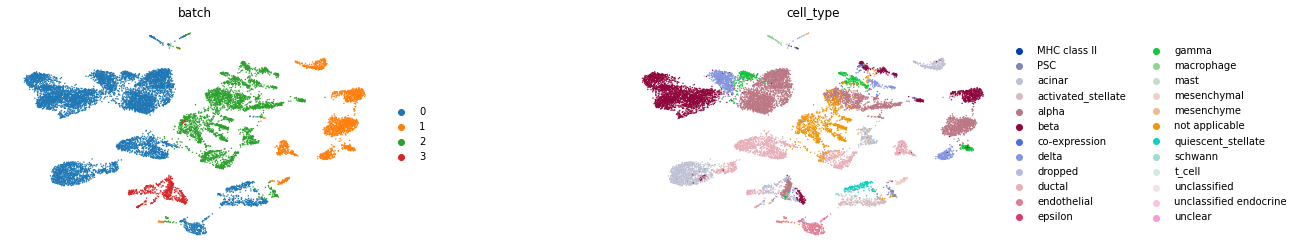

In [6]:
sc.pl.umap(train, color=["batch", "cell_type"], wspace=.5, frameon=False)

### Preprocessing Data

In [7]:
train = scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="cell_type",  copy=True)

INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
WARNING  This dataset has some empty cells, this might fail inference.Data should be filtered
         with `scanpy.pp.filter_cells()`                                                     
WARNING  This dataset has some empty cells, this might fail inference.Data should be filtered
         with `scanpy.pp.filter_cells()`                                                     
WARNING  This dataset has some empty cells, this might fail inference.Data should be filtered
         with `scanpy.pp.filter_cells()`                                                     
WARNING  This dataset has some empty cells, this might fail 

## Creating and Saving the model¶

In [8]:
model = scgen.SCGEN(train)
model.save("../saved_models/model_batch_removal.pt", overwrite=True)

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


## Training the Model

In [9]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
    use_gpu=True
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27/100:  27%|██▋       | 27/100 [01:16<03:28,  2.85s/it, loss=765, v_num=1]


## Batch-Removal 

In [10]:
corrected_adata = model.batch_removal()
corrected_adata

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
WARNING  This dataset has some empty cells, this might fail inference.Data should be filtered
         with `scanpy.pp.filter_cells()`                                                     
WARNING  This dataset has some empty cells, this might fail inference.Data should be filtered
         with `scanpy.pp.filter_cells()`                                                     
WARNING  This dataset has some empty cells, this might fail inference.Data should be filtered
         with `scanpy.pp.filter_cells()`                    

AnnData object with n_obs × n_vars = 14693 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain', 'cell_type', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'concat_batch'
    uns: '_scvi'
    obsm: 'latent', 'corrected_latent'

### Visualization of the corrected gene expression data¶

         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'celltype' as categorical
... storing 'sample' as categorical
... storing 'batch' as categorical
... storing 'louvain' as categorical
... storing 'cell_type' as categorical


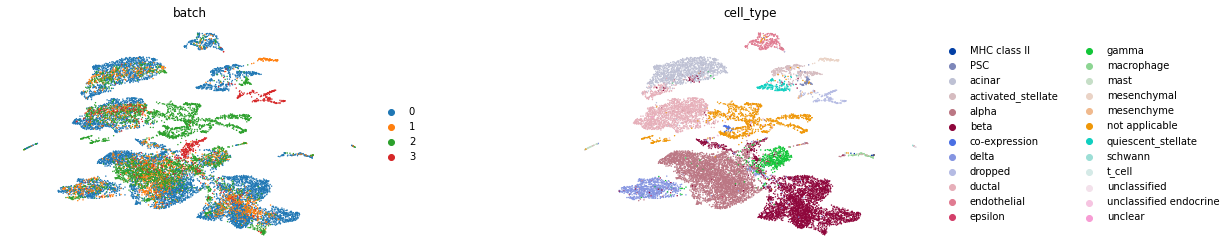

In [11]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

We can also use low-dim corrected gene expression data

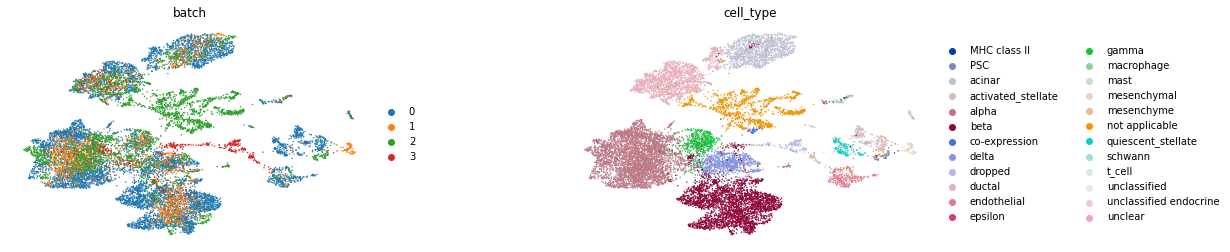

In [12]:
sc.pp.neighbors(corrected_adata, use_rep="corrected_latent")
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

### Using Uncorrected Data

Note that original adata.raw for the adata.raw is saved to corrected_adata.raw and you can use that for fruther analaysis

In [13]:
corrected_adata.raw

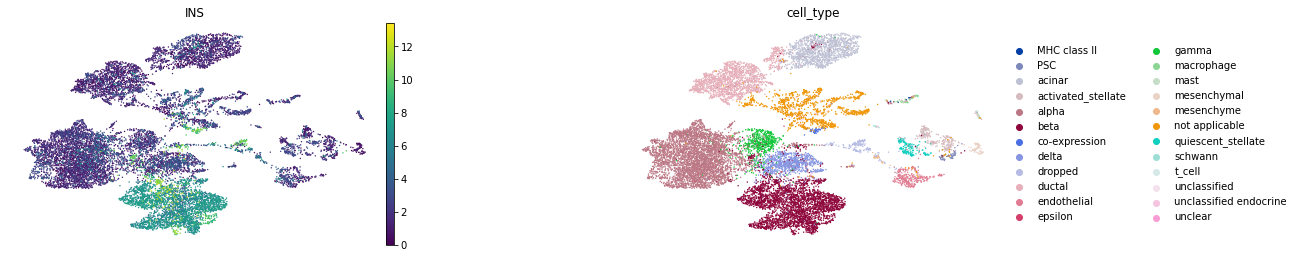

In [14]:
sc.pl.umap(corrected_adata, color=["INS", "cell_type"], wspace=.5, frameon=False, use_raw=True)
